In [1]:
from textwrap import dedent
import numpy as np
from numpy import dot
from scipy.linalg import solve
from quantecon.matrix_eqn import solve_discrete_riccati

class LQ(object):
    r"""
    this class if for analyzing linear quadratic optimal control
    problems of either the infinite horizon form
        
        min E sum_{t=0}^{\infty} beta^t r{x_t, u_t}
        
    with
    
        r{x_t, u_t} :=x_t' R x_t +u_t' Q u_t +2 u_t' N x_t
    
    or the finite horizon form
    
        min E sum_{t=0}^{T-1} beta^t r{x_t, u_t} +beta^T x_T' R_f x_T
    
    both are minimized subject to the law of motion
    
        x_{t+1} =A x_t +B u_t +C w_{t+1}
        
    here x is n x1, u is k x 1, w is j x 1 and the matrices are
    conformable for these dimensions. the sequence {w_t} is assumed to
    be while noice, with zero mean and E w_t w_t =I, the j x j
    identity.
    
    if C is not supplied as a parameter, the model is assumed to be
    deterministic (and C is set to a zero matrix of appropriate
    dimension)
    
    for this model, the time t value (i.e., cost-to-go) function V_t
    takes the form
    
        x' P_T x + d_T
        
    and the optimal policy is of the form u_T=-F_T x_T. In
    the infinite horizon case, V, P, d and F are all stationary.
    
    parameters
    ----------
    Q: array_like(float)
        Q is the payoff(or cost) matrix that corresponds with the
        control variable u and is k x k. should be symmetric and
        nonnegative definite
    R: array_like(float)
        R is the payoff(or cost) matrix that corresponds with the
        state variable x and is n x n. should be symmetric and
        non-negative definite
    N: array_like(float)
        N is the cross product term in the payoff, as above. it should
        be n x n
    A: array_like(float)
        A is part of the state transition as described above. it should
        be n x n
    B: array_like(float)
        B is part of the state transition as described above. it should
        be n x k
    C: array_like(float), optional(default=None)
        C is part of the state transition as described above. and
        corresponds to the random variable today. if the model is
        deterministic then C should take default value of None
    beta: scalar(float), optional(default=None)
        beta is the discount parameter
    T: scalar(int), optional(default=None)
        T is the number of periods in a finite horizon problem.
    Rf: array_like(float), optional(default=None)
        Rf is the final (in a finite horizon model) payoff(or cost)
        matrix that correspinds with the control variableu and is n x n.
        should be symmetric and non-negative definite
        
    attributes
    ---------
    Q, R, N, A, B, C, beta, T, Rf: see parameters
    P: array_like(float)
        P is part of the value function representation of V(x)=x'Px + d
    d: array_like(float)
        d is part of the value function representation of V(x)=x'Px + d
    F: array_like(float)
        F is the policy rule that determines the choice of control in
        each period.
    k, n, j: scalar(int)
        the dimensions of the matrices as presented above
        
    """
    
    def __init__(self, Q, R, A, B, C=None, N=None, beta=1, T=None, Rf=None):
        #==make sure all matrices can be treated as 2D arrays==#
        converter=lambda X: np.atleast_2d(np.asarray(X, dtype='float'))
        self.A, self.B, self.Q, self.R, self.N=list(map(converter, (A, B, Q, R, N)))
        #==record dimensions==#
        self.k, self.n=self.Q.shape[0], self.R.shape[0]
        
        self.beta=beta
        
        if C is None:
            #==if C not given, the model is deterministic, set C=0.==#
            self.j=1
            self.C=np.zeros((self.n, self.j))
            
        else:
            self.C=converter(C)
            self.j=self.C.shape[1]
            
        if N is None:
            #== No cross product term in payoff. Set N=0.==#
            self.N=np.zeros((self.k, self.n))
            
        if T:
            #==model is finite horizon==#
            self.T=T
            self.Rf=np.asarray(Rf, dtype='float')
            self.P=self.Rf
            self.d=0
        else:
            self.P=None
            self.d=None
            self.T=None
            
        self.F=None
        
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        m="""\
        Linear quadratic control system
            -beta(discount parameter): {b}
            -T(time horizon): {t}
            -n(number of state variables): {n}
            -k(number of control variables):{k}
            -j(number of shocks): {j}
        """
        t="infinite" if self.T is None else self.T
        return dedent(m.format(b=self.beta, n=self.n, k=self.k, j=self.j,
                              t=t))
    
    def update_values(self):
        """
        this method is for updating in the finite horizon case. it
        shifts the current value function
        
            V_t{x}=x' P_t x + d_t
            
        and the optimal policy F_t one step *back* in time,
        replacing the pair P_t and d_t with
        P_{t-1} and d_{t-1}, and F_t with
        F_{t-1}
        
        """
        #==simplify notation==#
        Q, R, A, B, N, C=self.Q, self.R, self.A, self.B, self.N, self.C
        P, d=self.P, self.d
        #==some useful matrices==#
        S1=Q+self.beta*dot(B.T, dot(P, B))
        S2=self.beta*dot(B.T, dot(P, A))+N
        S3=self.beta*dot(A.T, dot(P, A))
        #==compute F as (Q+B'PB)^{-1}(beta B'PA + N)==#
        self.F=solve(S1, S2)
        #==shift P back in time one step==#
        new_P=R-dot(S2.T, self.F) +S3
        #==recalling that trace(AB)=trace(BA)==#
        new_d=self.beta*(d + np.trace(dot(P, dot(C, C.T))))
        #==set new state==#
        self.P, self.d=new_P, new_d
        
    def stationary_values(self):
        """
        computes the matrix P and scalar d that represent the value
        function
        
            V(x)=x' P x + d
        
        in the infinite horizon case. also computes the control matrix
        F from u = -Fx
        
        returns
        ----------
        P: array_like(float)
            P is part of the value function representation of 
            V(x)=xPx + d
        F: array_like(float)
            F is the policy rule that determines the choice of control
            in each period.
        d: array_like(float)
            d is part of the value function representation of
            V(x)=xPx+ d
            
        """
        #==simplify notation==#
        Q, R, A, B, N, C=self.Q, self.R, self.A, self.B, self.N, self.C
        
        #==solve riccati equation, obtain P==#
        A0, B0 =np.sqrt(self.beta)*A, np.sqrt(self.beta)*B
        P=solve_discrete_riccati(A0, B0, R, Q, N)
        
        #==compute F==#
        S1=Q+self.beta*dot(B.T, dot(P, B))
        S2=self.beta*dot(B.T, dot(P, A))+N
        F=solve(S1, S2)
        
        #==compute d==#
        d=self.beta * np.trace(dot(P, dot(C, C.T)))/(1-self.beta)
        
        #==bind states and return values==#
        self.P, self.F, self.d=P, F, d
        
        return P, F, d
    
    def compute_sequence(self, x0, ts_length=None):
        """
        compute and return the optimal state and control sequences
        """
        
        #==simplify notation==#
        A, B, C=self.A, self.B, self.C
        
        #==preliminaries, finite horizon case==#
        if self.T:
            T=self.T if not ts_length else min(ts_length, self.T)
            self.P, self.d=self.Rf, 0
            
        #==preliminaries, infinite horizon case==#
        else:
            T=ts_length if ts_length else 100
            self.stationary_values()
            
        #==set up initial condition and array to store paths==#
        x0=np.asarray(x0)
        x0=x0.reshape(self.n,1) #make sure x0 is a column vector
        x_path =np.empty((self.n, T+1))
        u_path=np.empty((self.k, T))
        w_path=dot(C, np.random.randn(self.j, T+1))
        
        #==compute and record the sequence of policies==#
        policies=[]
        for t in range(T):
            if self.T: #finite horizon case
                self.update_values()
            policies.append(self.F)
            
        #==use policy sequance to generate states and controls==#
        F=policies.pop()
        x_path[:,0]=x0.flatten()
        u_path[:,0]=-dot(F, x0).flatten()
        for t in range(1, T):
            F =policies.pop()
            Ax, Bu=dot(A, x_path[:, t-1]),dot(B, u_path[:, t-1])
            x_path[:, t]=Ax+Bu+w_path[:, t]
            u_path[:, t]=-dot(F, x_path[:, t])
        Ax, Bu=dot(A, x_path[:, T-1]), dot(B, u_path[:, T-1])
        x_path[:, T]=Ax+Bu+w_path[:, T]
        
        return x_path, u_path, w_path

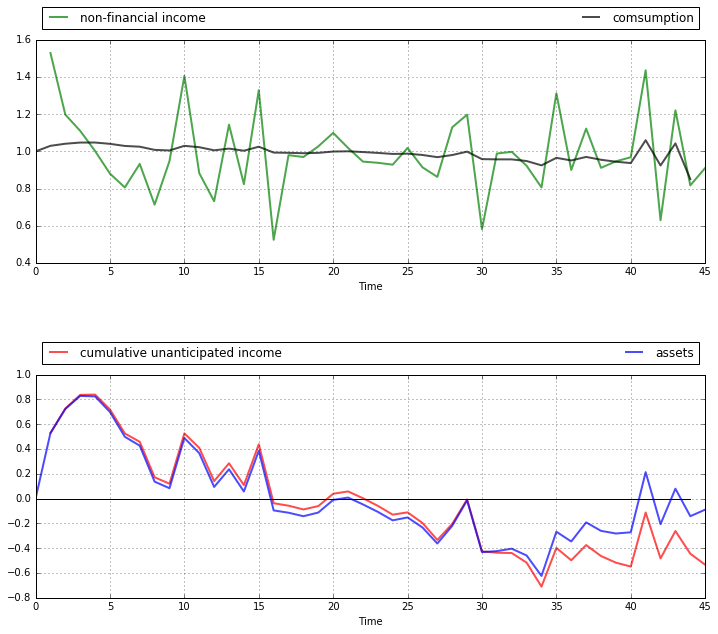

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#==model parameters==#
r=0.05
beta=1/(1+r)
T=45
c_bar=2
sigma=0.25
mu=1
q=1e6

#==formuate as an LQ problem==#
Q=1
R=np.zeros((2,2))
Rf=np.zeros((2,2))
Rf[0,0]=q
A=[[1+r, -c_bar+mu],
  [0,1]]
B=[[-1],
  [0]]
C=[[sigma],
  [0]]

#==compute solutions and simulate==#
lq=LQ(Q, R, A, B, C, beta=beta, T=T, Rf=Rf)
x0=(0, 1)
xp, up, wp=lq.compute_sequence(x0)

#==conver back to assets, consumption and income==#
assets=xp[0, :] # a_t
c=up.flatten()+c_bar #c_t
income=wp[0,1:]+mu #y_t

#==plot results==#
n_rows=2
fig, axes=plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox=(0., 1.02, 1., .102)
legend_args={'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args={'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="non-financial income",
            **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="comsumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(list(range(1, T+1)), np.cumsum(income-mu), 'r-',
            label="cumulative unanticipated income", **p_args)
axes[1].plot(list(range(T+1)), assets, 'b-', label="assets", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')
axes[1].legend(ncol=2, **legend_args)

plt.show()